MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

See Linkedin article

Build Super-resolution Gravity from GGMplus Free-Air Gravity Anomaly (200m) enhanced by SRTM topography (30m)

https://www.linkedin.com/pulse/build-super-resolution-gravity-from-ggmplus-free-air-200m-pechnikov/

In [1]:
from osgeo import gdal
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
%matplotlib inline

### Define helper functions

In [2]:
# Gal, or cm/s2
def ggmplus2013_v4_gal(tilename):
    # read binary data
    data=np.fromfile(tilename,dtype='>i4').astype(np.float32)
    size = int(np.sqrt(len(data)))
    data[data==-2**31] = np.nan
    # scale (0.1) and convert to Gal, or cm/s2
    data = 1e-4*data
    data = data.reshape(size,size,order='F')

    fname = os.path.basename(tilename)
    snflag,sn,ewflag,ew = 1 if fname[0]=='N' else -1,int(fname[1:3]),1 if fname[3]=='E' else -1,int(fname[4:7])
    lats = np.linspace(sn*snflag + 0.001, sn*snflag + 5 - 0.001,size)
    lons = np.linspace(ew*ewflag + 0.001, ew*ewflag + 5 - 0.001,size)
    # make Xarray
    da = xr.DataArray(data,
                          coords=[lats,lons],
                          dims=['lat','lon'])
    da.attrs['epsg'] = 4326
    return da

# function to load source GeoTIF image
def gdal_raster(src_filename, NoData=None):
    ds = gdal.Open(src_filename)
    datains = []
    NoDatas = []
    for bandidx in range(ds.RasterCount):
        # read NoData value from raster (if possible)
        band = ds.GetRasterBand(bandidx+1)
        datain = np.array(band.ReadAsArray())
        if NoData is None:
            nodatain = band.GetNoDataValue()
            if nodatain is not None and datain.dtype == 'float32':
                NoData = nodatain
            elif nodatain is not None:
                # gdal returns float NoData value for integer bands
                NoData = int(nodatain) if int(nodatain) == nodatain else nodatain
            else:
                NoData = 0
        datains.append(datain)
        NoDatas.append(NoData)
    if len(datains) == 1:
        NoDatas = NoDatas[0]
        raster = xr.DataArray(datains[0],
                          coords=[range(ds.RasterYSize),range(ds.RasterXSize)],
                          dims=['lat','lon'])
    else:
        if np.all(NoDatas) == NoDatas[0]:
            NoDatas = NoDatas[0]
        else:
            NoDatas = np.array(NoDatas)
        raster = xr.DataArray(datains,
                          coords=[range(ds.RasterCount),range(ds.RasterYSize),range(ds.RasterXSize)],
                          dims=['band','lat','lon'])
    
    ulx, xres, xskew, uly, yskew, yres  = ds.GetGeoTransform()
    lrx = ulx + (ds.RasterXSize - 1) * xres
    lry = uly + (ds.RasterYSize - 1) * yres

    raster.lat.values = uly + yres*(raster.lat.values + 0.5)
    raster.lon.values = ulx + xres*(raster.lon.values + 0.5)
    
    raster.attrs['nodata'] = NoDatas
    
    return raster

# low-pass filter
def raster_filter(src, gamma):
    dst = src.copy()
    dst.values = gaussian_filter(dst.values.astype(np.float32),gamma,mode='constant', cval=np.nan)
    return dst

### Define projected grid resolution [m]
Distance in meters between two cells centers on the surface 

In [3]:
# rasters below defined in decimal degrees
# this coefficient for pixel-based filtering and plotting
resolution = 30

### Define target area

In [4]:
# the exact target area without any border
def crop_area(src):
    return src.sel(lon=slice(117,117.5),lat=slice(-9,-8.5))
def crop_area_small(src):
    return src.sel(lon=slice(117.1,117.2001),lat=slice(-8.6,-8.5))

### Load GGMplus (Global Gravity Model plus) Gravity Acceleration dataset 200m
http://ddfe.curtin.edu.au/gravitymodels/GGMplus/GGMplus_readme.dat

In [5]:
# Free-Air Gravity
fa = ggmplus2013_v4_gal("S10E115.ga")

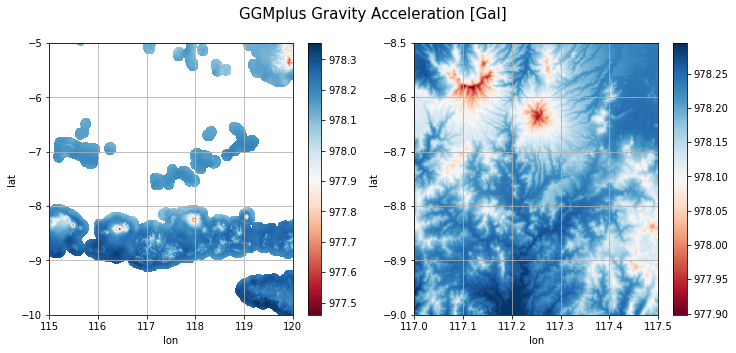

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

fa.plot(cmap='RdBu', ax=ax1)
ax1.grid()
crop_area(fa).plot(cmap='RdBu', ax=ax2)
ax2.grid()

plt.suptitle("GGMplus Gravity Acceleration [Gal]\n", fontsize=15)
plt.show()

### Load SRTM topography 30m

In [7]:
# this is SRTM 30m for the same area as GGMplus data above
et = gdal_raster("SRTM30m.S10E115.tif")
# invert latitude axis
et.values = et.values[::-1]
et.lat.values = et.lat.values[::-1]
# change datatype to use NaN values as NoData
# (NaN is not possible integer value)
et.values = et.values.astype(float)
et.values[et.values==et.nodata] = np.nan

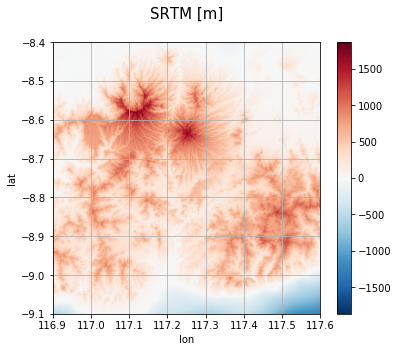

In [8]:
plt.figure(figsize=(6,5))
et.plot(cmap='RdBu_r')
plt.grid()
plt.title("SRTM [m]\n", fontsize=15)
plt.show()

### Original GGMplus Gravity Acceleration 200m and SRTM topography 30m

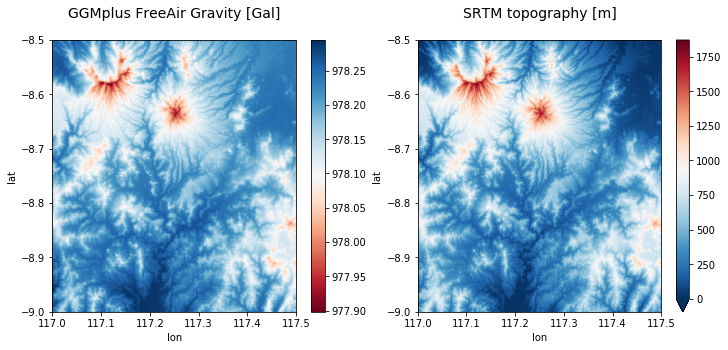

In [9]:
# larger area
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

crop_area(fa).plot(cmap='RdBu',ax=ax1)
ax1.set_title('GGMplus FreeAir Gravity [Gal]\n', fontsize=14)
crop_area(et).plot(vmin=0,cmap='RdBu_r',ax=ax2)
ax2.set_title('SRTM topography [m]\n', fontsize=14)

plt.show()

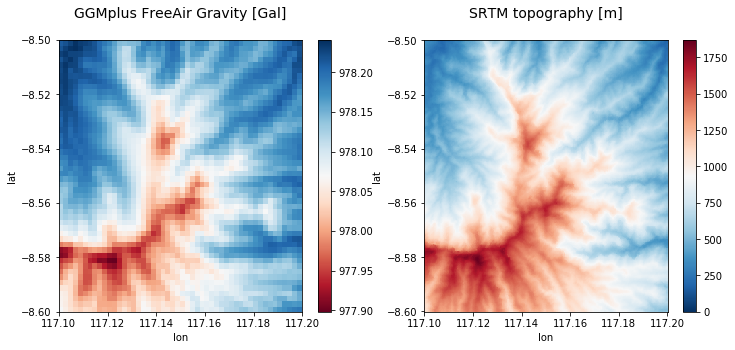

In [10]:
# smaller area
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

crop_area_small(fa).plot(cmap='RdBu',ax=ax1)
ax1.set_title('GGMplus FreeAir Gravity [Gal]\n', fontsize=14)
crop_area_small(et).plot(vmin=0,cmap='RdBu_r',ax=ax2)
ax2.set_title('SRTM topography [m]\n', fontsize=14)

plt.show()

### Regrid GGMplus Gravity Acceleration 200m on the same grid as SRTM topography 30m
This is nearest neighbor interpolation without any data quality enhancement

In [11]:
# define source values
df_fa = fa.to_dataframe(name='fa').dropna().reset_index()
# target grid 
df_grid = et.to_dataframe(name='_').reset_index()[['lat','lon']]
# nearest neighbor interpolation
tree = cKDTree(list(zip(df_fa.lon, df_fa.lat)))
distance, indices = tree.query(list(zip(df_grid.lon, df_grid.lat)), k = 1)
values = df_fa.fa.values[indices]
fa_30m = xr.DataArray(values.reshape(et.shape),
                          coords=[et.lat,et.lon])

### Enhance GGMplus Gravity Acceleration by SRTM topography 30m
As explained in the article we need to transfer spatial components 0-500m

With pixel size 30m the required filter radius is equal to 17 because 17*30m ~= 500m

In [12]:
# caclulate approximate scale factor for short wavelenghs
scale = -(crop_area(et).max()-crop_area(et).min())/(crop_area(fa).max()-crop_area(fa).min())

In [13]:
# define spectrum components to enhance the gravity
# 500m waveband with resolution 30m
radius = round(500/30)

et_lowpass = crop_area(raster_filter(et, radius))
et_hipass  = crop_area(et - et_lowpass)

fa_lowpass = crop_area(raster_filter(fa_30m, radius))
fa_hipass  = crop_area(fa_30m - fa_lowpass)

# super-resolution gravity dataset
fa_hires = fa_lowpass + et_hipass/scale

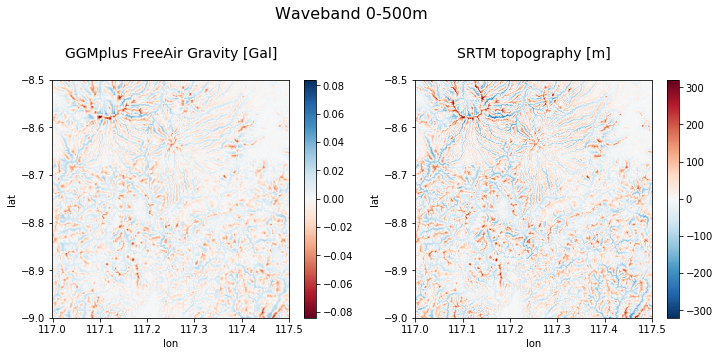

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

crop_area(fa_hipass).plot(cmap='RdBu',ax=ax1)
ax1.set_title('GGMplus FreeAir Gravity [Gal]\n', fontsize=14)
crop_area(et_hipass).plot(cmap='RdBu_r',ax=ax2)
ax2.set_title('SRTM topography [m]\n', fontsize=14)

plt.suptitle('Waveband 0-500m', fontsize=16)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.show()

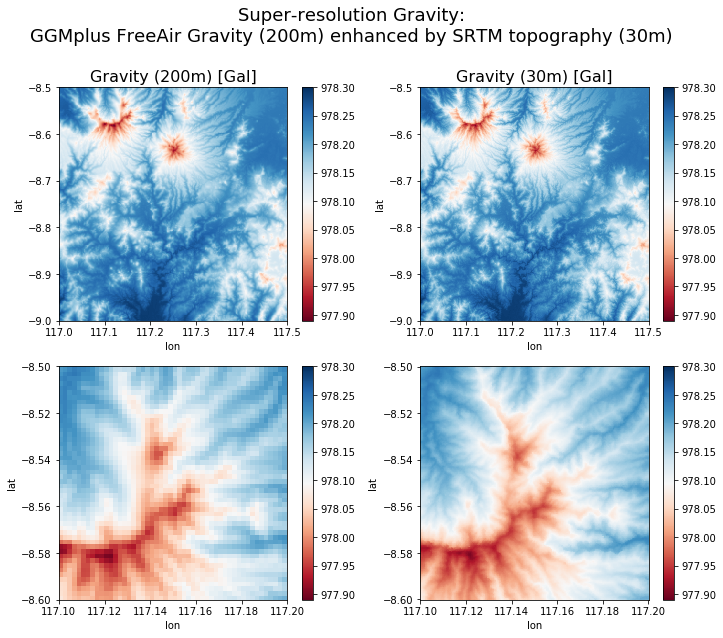

In [15]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10.5,9))

title = 'Super-resolution Gravity:\nGGMplus FreeAir Gravity (200m) enhanced by SRTM topography (30m)'

crop_area(fa).plot(vmin=977.89,vmax=978.30, cmap='RdBu',ax=ax1)
ax1.set_title('Gravity (200m) [Gal]', fontsize=16)
crop_area(fa_hires).plot(vmin=977.89,vmax=978.30, cmap='RdBu',ax=ax2)
ax2.set_title('Gravity (30m) [Gal]', fontsize=16)

crop_area_small(fa).plot(vmin=977.89,vmax=978.30, cmap='RdBu',ax=ax3)
crop_area_small(fa_hires).plot(vmin=977.89,vmax=978.30, cmap='RdBu',ax=ax4)

plt.suptitle(title, fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.show()

### Simple validation
Use the scale factor to check the spectrum components transfer per cells 200m x 200m

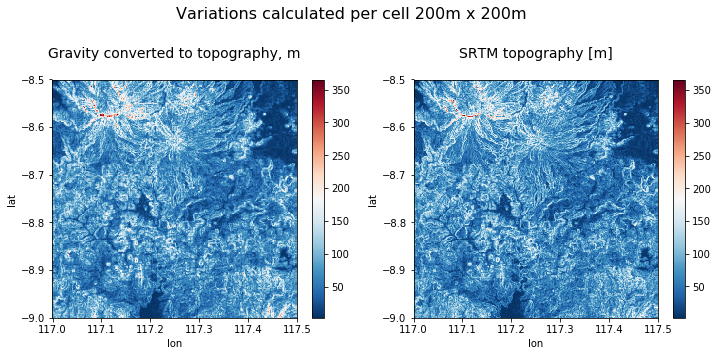

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

# maximal difference between source gravity and target gravity
# calculated for the each source gravity cell (200m x 200m)
fa_difference_m = (scale*(crop_area(fa_30m)-crop_area(fa_hires)))
(fa_difference_m.coarsen({'lon':7,'lat':7},boundary='trim').max() \
     - fa_difference_m.coarsen({'lon':7,'lat':7},boundary='trim').min()).plot(cmap='RdBu_r', ax=ax1)
ax1.set_title('Gravity converted to topography, m\n', fontsize=14)

# maximal difference between the source topology values
# calculated for the each source gravity cell (200m x 200m)
(crop_area(et).coarsen({'lon':7,'lat':7},boundary='trim').max() \
     - crop_area(et).coarsen({'lon':7,'lat':7},boundary='trim').min()).plot(cmap='RdBu_r', ax=ax2)
ax2.set_title('SRTM topography [m]\n', fontsize=14)

plt.suptitle('Variations calculated per cell 200m x 200m', fontsize=16)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.show()

### Conclusion

The scale factor for the spectrum components transfer (0-500m wavelengths) is calculated by global difference for area 0.5° x 0.5°

The produced gravity variation is checked by applying the scale factor per cell size 200m x 200m and compare to the topology variations for the same cells. These two products are almost equal (see plot above) - the same picture with the same values. That's means the produced super-resolution gravity is correct enough.